In [1]:
import ROOT
import ROOT.ROOT as rr

import uproot
import numpy as np
import pandas as pd
import os
from pathlib import Path
import awkward as ak

import random

Welcome to JupyROOT 6.24/00


### Implementation of the skimming step of the analysis

The skimming step reduces the inital generic samples to a dataset optimized for this specific analysis. Most important, the skimming removes all events from the initial dataset, which are not of interest for our study.

In [2]:
dirBasePath  = '/data/FCNC/'
dirOutPath = '/data/Skim/'
dirPlotPath = './Plots/'

listDir = os.listdir(dirBasePath)

In [3]:
def returnDir(string):
    return [filename for filename in listDir if filename.startswith(string)]

def loadData(chain, pathDirs):
    # Set up multi-threading capability of ROOT
    rr.EnableImplicitMT()
    
    for Dir in pathDirs:
        print('>>> Process directory ', Dir)
        file_list = os.listdir(dirBasePath + Dir)
        for file in file_list:
            chain.AddFile(dirBasePath + Dir + '/' + file)
            
    return chain

def CountEvents(df):
    n = df.Count().GetValue()
    print('\nNumber of events:', n, '\n')

In [4]:
# - Data + MC Signal
signalDirs = returnDir('SingleMuon')
signalMCDirs = returnDir('TT_FCNC')

# - MC backgrounds
listBkgDir = ['DYJetsToLL_M', 'QCD', 'ST_s', 'ST_t', 'ST_tW_antitop', 'ST_tW_top', 'TTTT_Tune', 'TTTo2L2Nu', 'TTToHadronic',
              'TTToSemiLeptonic', 'TTWJetsToLNu', 'TTZToLLNuNu', 'WGToLNuG', 'WJetsToLNu', 'WWTo2L2Nu', 'WWW', 'WWZ', 'WZG',
              'WZTo1L1Nu2Q', 'WZTo2L2Q', 'WZTo3LNu', 'WZZ', 'WmWmJJ', 'WminusH', 'WpWpJJ', 'ZG', 'ZZ', 'tZq']

bkgMCDirs = dict(list(zip(listBkgDir, map(returnDir, listBkgDir))))
bkgMCChain = dict(list(zip(listBkgDir, [ROOT.TChain('Events') for _ in range(len(listBkgDir))])))

In [ ]:
def FSkim1(df):
    fdf = df.Filter('iSkim == 1', 'iSkim1')\
            .Filter('nCleanJet >= 4 && nBJet > 0 && nBJet <= 2', 'GoodJet')\
            .Define('mask', 'Muon_pfRelIso03_all < 0.15 && Muon_pt > 7')\
            .Define('nGoodMu', 'Sum(mask)')\
            .Define('Muon_pt15', 'Muon_pt[mask]')\
            .Filter('nGoodMu >= 2', 'GoodEvent')
    return fdf

In [5]:
def FSkim3(df):
    fdf = df.Filter('iSkim == 3', 'iSkim3')\
            .Filter('nCleanJet >= 2 && nBJet >= 1', 'GoodJet')\
            .Define('mask', 'Muon_pfRelIso03_all < 0.15 && Muon_pt > 15')\
            .Define('nGoodMu', 'Sum(mask)')\
            .Define('Muon_pt15', 'Muon_pt[mask]')\
            .Filter('nGoodMu >= 3', 'GoodEvent')
    return fdf

In [6]:
# - Load Data + MC Signal

chainSig = ROOT.TChain('Events')
dfSig = rr.RDataFrame(loadData(chainSig, signalDirs))
CountEvents(dfSig)

chainMC = ROOT.TChain('Events')
dfMCSig = rr.RDataFrame(loadData(chainMC, signalMCDirs))
CountEvents(dfMCSig)

>>> Process directory  SingleMuon_Run2017B-Nano1June2019-v1
>>> Process directory  SingleMuon_Run2017E-Nano1June2019-v1
>>> Process directory  SingleMuon_Run2018D-Nano1June2019-v1
>>> Process directory  SingleMuon_Run2016G-Nano1June2019-v1
>>> Process directory  SingleMuon_Run2018C-Nano1June2019-v1
>>> Process directory  SingleMuon_Run2017C-Nano1June2019-v1
>>> Process directory  SingleMuon_Run2017D-Nano1June2019-v1
>>> Process directory  SingleMuon_Run2016E-Nano1June2019-v1
>>> Process directory  SingleMuon_Run2016B_ver1-Nano1June2019_ver1-v1
>>> Process directory  SingleMuon_Run2016C-Nano1June2019-v1
>>> Process directory  SingleMuon_Run2016B_ver2-Nano1June2019_ver2-v1
>>> Process directory  SingleMuon_Run2017F-Nano1June2019-v1
>>> Process directory  SingleMuon_Run2016D-Nano1June2019-v1
>>> Process directory  SingleMuon_Run2018A-Nano1June2019-v1
>>> Process directory  SingleMuon_Run2016F-Nano1June2019-v1
>>> Process directory  SingleMuon_Run2018B-Nano1June2019-v1
>>> Process director

In [8]:
# -Load MC backgrounds

dfMCBkg = {}
for key, value in bkgMCDirs.items():
    dfMCBkg[key] = rr.RDataFrame(loadData(bkgMCChain[key], value))
    CountEvents(dfMCBkg[key])

>>> Process directory  DYJetsToLL_M-50_TuneCP5_13TeV-amcatnloFXFX-pythia8_RunIIAutumn18
>>> Process directory  DYJetsToLL_M-10to50_TuneCP5_13TeV-madgraphMLM-pythia8_RunIIAutumn18
>>> Process directory  DYJetsToLL_M-10to50_TuneCP5_13TeV-madgraphMLM-pythia8_RunIIFall17
>>> Process directory  DYJetsToLL_M-50_TuneCP5_13TeV-amcatnloFXFX-pythia8_RunIIFall17
>>> Process directory  DYJetsToLL_M-10to50_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_RunIISummer16
>>> Process directory  DYJetsToLL_M-50_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8_RunIISummer16

Number of events: 89688 

>>> Process directory  QCD_HT1500to2000_TuneCP5_13TeV-madgraph-pythia8_RunIIFall17
>>> Process directory  QCD_HT500to700_TuneCP5_13TeV-madgraphMLM-pythia8_RunIIAutumn18
>>> Process directory  QCD_HT700to1000_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_RunIISummer16
>>> Process directory  QCD_HT500to700_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_RunIISummer16
>>> Process directory  QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8_RunI


Number of events: 137131 

>>> Process directory  WWTo2L2Nu_DoubleScattering_13TeV-pythia8_RunIIFall17
>>> Process directory  WWTo2L2Nu_DoubleScattering_13TeV-pythia8_RunIISummer16
>>> Process directory  WWTo2L2Nu_13TeV-powheg_RunIISummer16
>>> Process directory  WWTo2L2Nu_DoubleScattering_13TeV-pythia8_RunIIAutumn18
>>> Process directory  WWTo2L2Nu_NNPDF31_TuneCP5_13TeV-powheg-pythia8_RunIIAutumn18
>>> Process directory  WWTo2L2Nu_NNPDF31_TuneCP5_13TeV-powheg-pythia8_RunIIFall17

Number of events: 18921 

>>> Process directory  WWW_4F_TuneCP5_13TeV-amcatnlo-pythia8_RunIIAutumn18
>>> Process directory  WWW_4F_TuneCP5_13TeV-amcatnlo-pythia8_RunIIFall17
>>> Process directory  WWW_4F_TuneCUETP8M1_13TeV-amcatnlo-pythia8_RunIISummer16

Number of events: 4769 

>>> Process directory  WWZ_4F_TuneCP5_13TeV-amcatnlo-pythia8_RunIIFall17
>>> Process directory  WWZ_TuneCP5_13TeV-amcatnlo-pythia8_RunIIAutumn18
>>> Process directory  WWZ_TuneCUETP8M1_13TeV-amcatnlo-pythia8_RunIISummer16

Number of 

### Histograms: save in `.root` extension

In [9]:
ROOT.gROOT.SetBatch(True)

################################################################################
# Declare the range of the histogram for each variable
#
# Each entry in the dictionary contains of the variable name as key and a tuple
# specifying the histogram layout as value. The tuple sets the number of bins,
# the lower edge and the upper edge of the histogram.
################################################################################

default_nbins = 30
ranges = {
#         'Electron_pt': (default_nbins, 10, 200),
        'Muon_pt15': (default_nbins, 15, 200),
#         'Electron_eta': (default_nbins, -5, 5),
#         'Muon_eta': (default_nbins, -5, 5),
#         'Jet_pt': (default_nbins, 10, 500),
#         'Jet_eta': (default_nbins, -5, 5),
        }

# Book a histogram for a specific variable
def bookHistogram(df, variable, range_):
    return df.Histo1D(rr.RDF.TH1DModel(variable, variable, range_[0], range_[1], range_[2]), variable, 'eventWeightLumi')

# Write a histogram with a given name to the output ROOT file
def writeHistogram(h, name):
    h.SetName(name)
    h.Write()

################################################################################
# Main function of the histogramming step
#
# The function loops over the outputs from the skimming step and produces the
# required histograms for the final plotting.
################################################################################

def main():
    # Set up multi-threading capability of ROOT
    rr.EnableImplicitMT()
    
    # Create output file
    tfile = ROOT.TFile(dirPlotPath + 'histograms.root', 'RECREATE')
    variables = ranges.keys()
    
    fdfSig = FSkim3(dfSig)
#     fdfMC = FSkim3(dfMC)
    
    # Loop through skimmed datasets and produce histograms of variables
    hists = {}
    for variable in variables:
        hists[variable] = bookHistogram(fdfSig, variable, ranges[variable])

#     hists_mc = {}
#     for variable in variables:
#         hists_mc[variable] = bookHistogram(fdfMC, variable, ranges[variable])

    # Write histograms to output file
    for variable in variables:
        writeHistogram(hists[variable], '{}_{}'.format('data', variable))
#     for variable in variables:
#         writeHistogram(hists_mc[variable], '{}_{}'.format('MCSig', variable))
        
    
    for key, value in dfMCBkg.items():
        fdfMCBkg = FSkim3(value)
        
        hists = {}
        for variable in variables:
            hists[variable] = bookHistogram(fdfMCBkg, variable, ranges[variable])
        for variable in variables:
            writeHistogram(hists[variable], '{}_{}'.format(key, variable))
    
    tfile.Close()

if __name__ == '__main__':
    main()

### Final plotting

In [10]:
################################################################################
# Implementation of the plotting step of the analysis
################################################################################

# Declare a human-readable label for each variable
labels = {
#         'Electron_pt': 'Electron p_{T} / GeV',
        'Muon_pt15': 'Muon p_{T} / GeV',
#         'Electron_eta': 'Electron #eta',
#         'Muon_eta': 'Muon #eta',
#         'Jet_pt': 'Jet p_{T} / GeV',
#         'Jet_eta': 'Jet #eta',
        }

# Specify the color for each process

# - Signal
colors = {
        'data': ROOT.TColor.GetColor('#BF2229'),
        'MCSig': ROOT.TColor.GetColor('#00A88F'),
        }
### - MC BKG
random.seed(123456)
colorsBkg = {} #ROOT.TColor.GetColor
for i in listBkgDir:
    colorsBkg[i] = ROOT.TColor.GetColor(random.randint(0,255), random.randint(0,255), random.randint(0,255))


# Retrieve a histogram from the input file based on the process and the variable name
def getHistogram(tfile, name, variable, tag=''):
    name = '{}_{}{}'.format(name, variable, tag)
    h = tfile.Get(name)
    if not h:
        raise Exception('Failed to load histogram {}.'.format(name))
    return h

################################################################################

# Main function of the plotting step
def main(variable):
    tfile = ROOT.TFile(dirPlotPath + 'histograms.root', 'READ')

    # Styles
    ROOT.gStyle.SetOptStat(0)

    ROOT.gStyle.SetCanvasBorderMode(0)
    ROOT.gStyle.SetCanvasColor(ROOT.kWhite)
    ROOT.gStyle.SetCanvasDefH(600)
    ROOT.gStyle.SetCanvasDefW(600)
    ROOT.gStyle.SetCanvasDefX(0)
    ROOT.gStyle.SetCanvasDefY(0)

    ROOT.gStyle.SetPadTopMargin(0.08)
    ROOT.gStyle.SetPadBottomMargin(0.13)
    ROOT.gStyle.SetPadLeftMargin(0.16)
    ROOT.gStyle.SetPadRightMargin(0.05)

    ROOT.gStyle.SetHistLineColor(1)
    ROOT.gStyle.SetHistLineStyle(0)
    ROOT.gStyle.SetHistLineWidth(1)
    ROOT.gStyle.SetEndErrorSize(2)
    ROOT.gStyle.SetMarkerStyle(20)

    ROOT.gStyle.SetOptTitle(0)
    ROOT.gStyle.SetTitleFont(42)
    ROOT.gStyle.SetTitleColor(1)
    ROOT.gStyle.SetTitleTextColor(1)
    ROOT.gStyle.SetTitleFillColor(10)
    ROOT.gStyle.SetTitleFontSize(0.05)

    ROOT.gStyle.SetTitleColor(1, 'XYZ')
    ROOT.gStyle.SetTitleFont(42, 'XYZ')
    ROOT.gStyle.SetTitleSize(0.05, 'XYZ')
    ROOT.gStyle.SetTitleXOffset(1.00)
    ROOT.gStyle.SetTitleYOffset(1.60)

    ROOT.gStyle.SetLabelColor(1, 'XYZ')
    ROOT.gStyle.SetLabelFont(42, 'XYZ')
    ROOT.gStyle.SetLabelOffset(0.007, 'XYZ')
    ROOT.gStyle.SetLabelSize(0.04, 'XYZ')

    ROOT.gStyle.SetAxisColor(1, 'XYZ')
    ROOT.gStyle.SetStripDecimals(True)
    ROOT.gStyle.SetTickLength(0.03, 'XYZ')
    ROOT.gStyle.SetNdivisions(510, 'XYZ')
    ROOT.gStyle.SetPadTickX(1)
    ROOT.gStyle.SetPadTickY(1)

    ROOT.gStyle.SetPaperSize(20., 20.)
    ROOT.gStyle.SetHatchesLineWidth(5)
    ROOT.gStyle.SetHatchesSpacing(0.05)

    ROOT.TGaxis.SetExponentOffset(-0.08, 0.01, 'Y')
    
    legend = ROOT.TLegend(0.5, 0.3, 0.9, 0.8)
    legend.SetNColumns(2)

    # Data + MC
    data = getHistogram(tfile, 'data', variable)
#     MCSig = getHistogram(tfile, 'MCSig', variable)
    
    stack = ROOT.THStack('', '')
    for key, value in colorsBkg.items():
        histo = getHistogram(tfile, key, variable)
        histo.SetLineWidth(0)
        histo.SetFillColor(value)
        stack.Add(histo)
        legend.AddEntry(histo, key, 'f')

    # Draw histograms
    data.SetMarkerStyle(20)
    data.SetLineColor(ROOT.kBlack)
    data.SetLineWidth(3)
#     MCSig.SetLineColor(colors['MCSig'])
#     MCSig.SetLineWidth(3)

    c = ROOT.TCanvas('', '', 600, 600)
    
    name = data.GetTitle()
    if name in labels:
        title = labels[name]
    else:
        title = name

#     MCSig.Draw('HIST SAME')
    stack.Draw('hist')
    data.Draw('E1P SAME')
    
    stack.GetXaxis().SetTitle(labels[variable])
    stack.GetYaxis().SetTitle('N_{Events}')
    stack.SetMaximum(max(stack.GetMaximum(), data.GetMaximum()) * 1.2)
    stack.SetMinimum(1.0)

    # Add legend
#     legend.AddEntry(MCSig, 'MCSig', 'f')
    legend.AddEntry(data, 'Data', 'lep')
    legend.SetBorderSize(0)
    legend.Draw()

    # Add title
    latex = ROOT.TLatex()
    latex.SetNDC()
    latex.SetTextSize(0.04)
    latex.SetTextFont(42)
    latex.DrawLatex(0.16, 0.935, '#bf{CMS FCNC}')

    # Save
    c.SaveAs(dirPlotPath + '{}.pdf'.format(variable))
    c.SaveAs(dirPlotPath + '{}.png'.format(variable))
#     ROOT.gROOT.GetListOfCanvases().Draw()

# Loop over all variable names and make a plot for each
if __name__ == '__main__':
    for variable in labels.keys():
        main(variable)

Info in <TCanvas::Print>: pdf file ./Plots/Muon_pt15.pdf has been created
Info in <TCanvas::Print>: png file ./Plots/Muon_pt15.png has been created


Muon_pt15.png



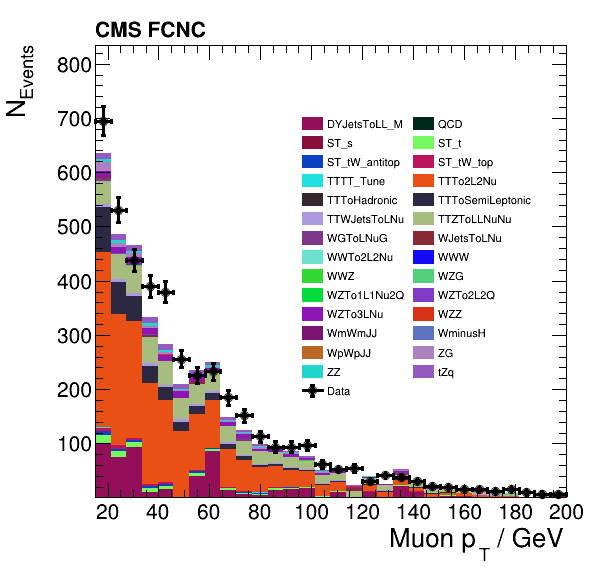

In [11]:
from IPython.display import Image
for image in os.listdir(dirPlotPath):
    if image.endswith('.png'):
        print(image + '\n')
        img = Image(filename=(dirPlotPath + image))
        display(img)

***
### Examples and trials

### Using UPROOT

In [ ]:
files = uproot.concatenate([(samplesBasePath + folder + '/*.root:Events') for folder in signalDirs])
dataframe = ak.to_pandas(files)
dataframe

In [ ]:
file = uproot.open('/data/FCNC/SingleMuon_Run2016C-Nano1June2019-v1/04F1FCBB-0E6C-174B-AECD-512E8CDCBC1A_Skim.root')
tree = file['Events']
tree.keys()

# tree.arrays(['luminosityBlock'],library='pd')

### Histogram example

In [ ]:
histo = FSkim3(dfSig).Histo1D(rr.RDF.TH1DModel('Muon_pt', 'Muon_pt', 30, 0, 200), 'Muon_pt')
c = ROOT.TCanvas('Hist','',800,600);
c.cd();
histo.Draw();
c.Draw();

In [ ]:
%%cpp
// example of filtering operation MC events
using namespace ROOT;

RDataFrame d('Events', '/data/FCNC/TT_FCNC-aTtoHJ_Tleptonic_HToWWZZtautau_eta_hct-MadGraph5-pythia8_RunIISummer16/6319226B-F5F4-1B45-950E-36BE5993AA49_Skim.root');
//auto c = d.Filter('iSkim != 1 && iSkim != 2 && iSkim != 3 && iSkim != 4').Count();
//std::cout << *c << std::endl;
                
hz = d.Histo1D('nElectron');

### Processing file by file w/o `Chain`

In [ ]:
# def main():

# Set up multi-threading capability of ROOT
rr.EnableImplicitMT()

for signalDir in signalDirs:
    print('>>> Process directory ', signalDir, ':')

#     df = rr.RDataFrame('Events' samplesBasePath + signalDir + '/*.root')
#     print('Number of events:', df.Count())

    df2 = MinimalSelection(df)
    
    df2.Report().Snapshot('Events', dirOutPath + signalDir + 'Fltr.root', finalVariables);

***
Loading of `.root` files through flattening with `uproot`.

In [ ]:
uproot.lazy([basepath+'SingleMuon_Run2017B-Nano1June2019-v1/*.root:Events'], filter_name='nMuon')

In [ ]:
uproot.concatenate([basepath + '{}/*.root:events'.format(folder for folder in return_dir('SingleMuon'))], filter_name='nMuon')

#### To clarify:
- istogrammi
- criteri per i tagli + iSkim
- nJet +- stringente di BJet


- BDT: discriminazione segnale/bkg


- Esame MAPD